In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from seysmo.models.model_class import CNN
from seysmo.models.train_model import train, evaluate
from seysmo.models.utils import save_model, load_model, count_parameters
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics import MeanAbsolutePercentageError
from torchvision.transforms import ToTensor
from torchviz import make_dot
import onnx

import mlflow

In [2]:
data = np.load("../data/processed/max_inputs.npy")
data.shape

(33133, 33, 438)

In [3]:
output = np.load("../data/processed/max_outputs.npy")
output.shape

(33133, 10)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, output, test_size=0.66, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.20, random_state=1)

In [5]:
print("Shape of train: ", y_train.shape)
print("Shape of test: ", y_test.shape)
print("Shape of validatation: ", y_val.shape)

Shape of train:  (11265, 10)
Shape of test:  (17494, 10)
Shape of validatation:  (4374, 10)


In [6]:
mlflow.set_tracking_uri("http://localhost:5000")

In [7]:
mlflow.set_experiment("/CNN_v0.1")

<Experiment: artifact_location='mlflow-artifacts:/444973925508816164', creation_time=1721852754748, experiment_id='444973925508816164', last_update_time=1721852754748, lifecycle_stage='active', name='/CNN_v0.1', tags={}>

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_channels = 1
conv_channels = [16, 32, 64]
conv_kernel_size = 3
pool_kernel_size = 2
fc_layers = [128, 64, 10]
input_shape = X_train[0].shape
epochs = 1000
batch_size = 32
learning_rate = 0.001
loss_fn = nn.MSELoss()
metric_fn = MeanAbsolutePercentageError().to(device)
model = CNN(in_channels=in_channels, conv_channels=conv_channels, kernel_size=conv_kernel_size, pool_size=pool_kernel_size, fc_layers=fc_layers, input_shape=input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
input_shape

(33, 438)

In [16]:
from torch.utils.data import Dataset

# X_train = X_train.astype(np.float32)
# X_val = X_val.astype(np.float32)
# X_test = X_test.astype(np.float32)

class SignalSpeedDataset(Dataset):
    def __init__(self, X, y):
        # Добавляем размер канала
        self.X = torch.from_numpy(X).unsqueeze(1).float()
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SignalSpeedDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = SignalSpeedDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SignalSpeedDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [17]:
train_dataset.X.shape

torch.Size([11265, 1, 33, 438])

In [18]:
with mlflow.start_run() as run:
    params = {
        "epochs": epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "loss_function": loss_fn.__class__.__name__,
        "metric_function": metric_fn.__class__.__name__,
        "optimizer": "ADAM",
        "in_channels": in_channels,
        "conv_channels": conv_channels,
        "conv_kernel_size": conv_kernel_size,
        "pool_kernel_size": pool_kernel_size,
        "fc_layers": fc_layers,
        "input_shape": input_shape
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("../models/model_P_summary.txt", "w", encoding="utf-8") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("../models/model_P_summary.txt")

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, metric_fn, optimizer, epoch=t, device=device)
        evaluate(val_dataloader, model, loss_fn, metric_fn, epoch=t, device=device)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

Epoch 1
-------------------------------
loss: 125393.304688 MAPE: 0.999999 [0 / 353]
loss: 2338.470459 MAPE: 0.115418 [100 / 353]
loss: 2600.041748 MAPE: 0.127868 [200 / 353]
loss: 2622.910645 MAPE: 0.116831 [300 / 353]
Eval metrics: 
MAPE: 0.12, Avg loss: 2185.262978 

Epoch 2
-------------------------------
loss: 2183.068115 MAPE: 0.117916 [0 / 353]
loss: 1619.368774 MAPE: 0.092189 [100 / 353]
loss: 1471.041748 MAPE: 0.093370 [200 / 353]
loss: 1275.872437 MAPE: 0.083896 [300 / 353]
Eval metrics: 
MAPE: 0.09, Avg loss: 1512.738054 

Epoch 3
-------------------------------
loss: 1166.172607 MAPE: 0.078399 [0 / 353]
loss: 1533.289185 MAPE: 0.080202 [100 / 353]
loss: 1320.309814 MAPE: 0.077931 [200 / 353]
loss: 1233.394409 MAPE: 0.082495 [300 / 353]
Eval metrics: 
MAPE: 0.09, Avg loss: 1442.045317 

Epoch 4
-------------------------------
loss: 1549.657593 MAPE: 0.092882 [0 / 353]
loss: 1302.140625 MAPE: 0.080216 [100 / 353]
loss: 1993.038696 MAPE: 0.090223 [200 / 353]
loss: 1206.783691 

2024/07/25 01:17:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Eval metrics: 
MAPE: 0.08, Avg loss: 1548.434649 


2024/07/25 01:17:26 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [19]:
num_batches = len(test_dataloader)
eval_loss, eval_mape = 0, 0
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        eval_loss += loss_fn(torch.reshape(pred, (-1, 10)), y).item()
        eval_mape += metric_fn(torch.reshape(pred, (-1, 10)), y).item()

eval_loss /= num_batches
eval_mape /= num_batches
print(f"Test loss: {eval_loss:4f}")
print(f"Test MAPE: {eval_mape:4f}")

Test loss: 1547.492532
Test MAPE: 0.083352


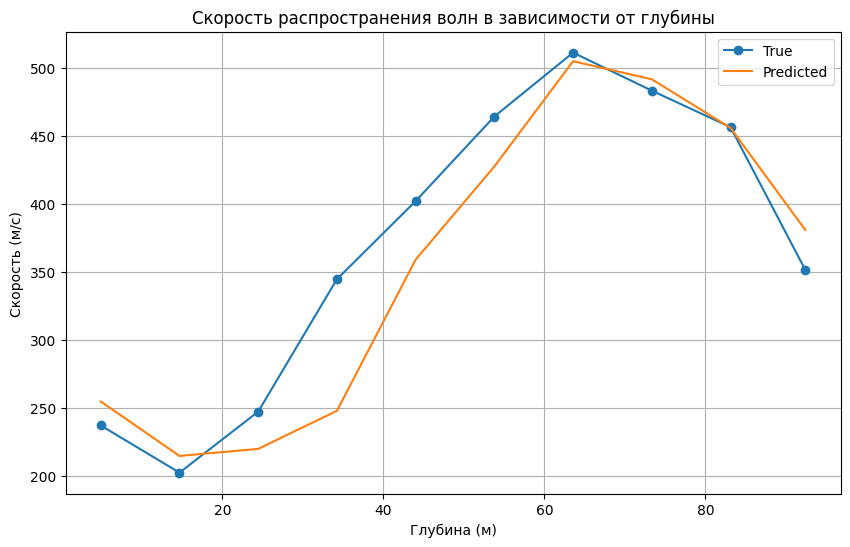

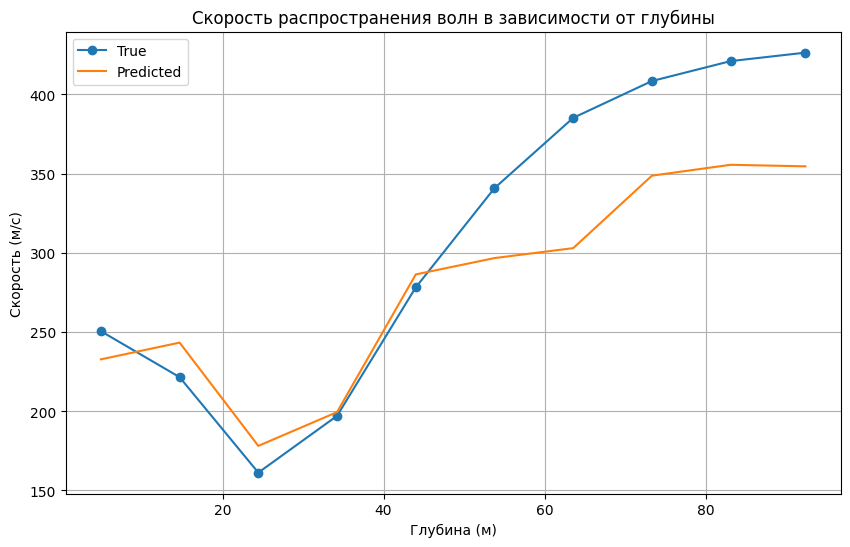

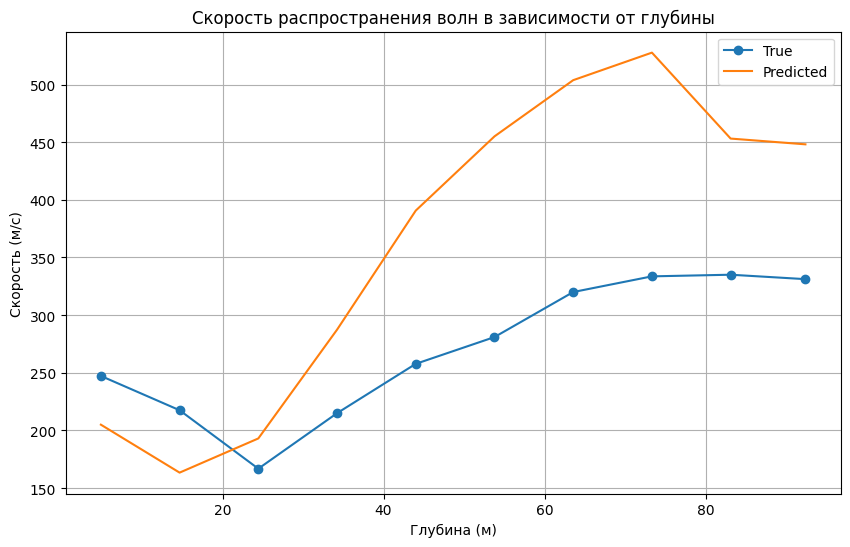

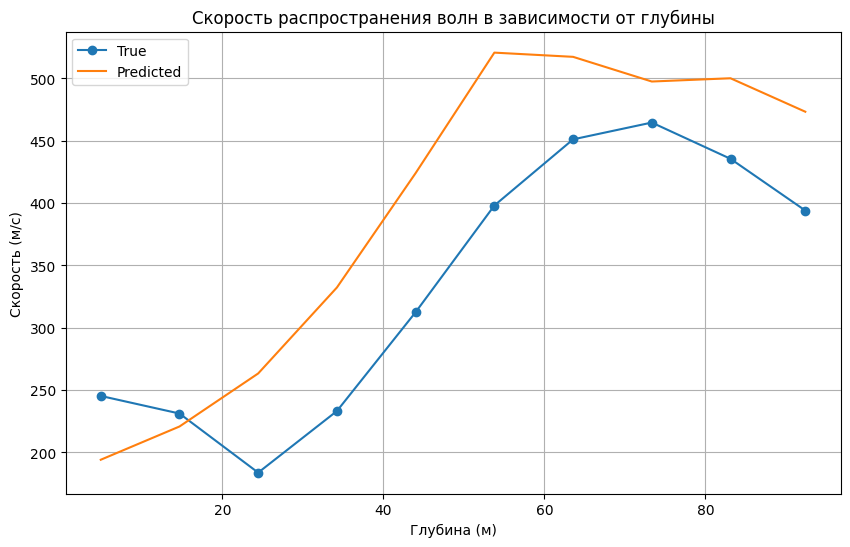

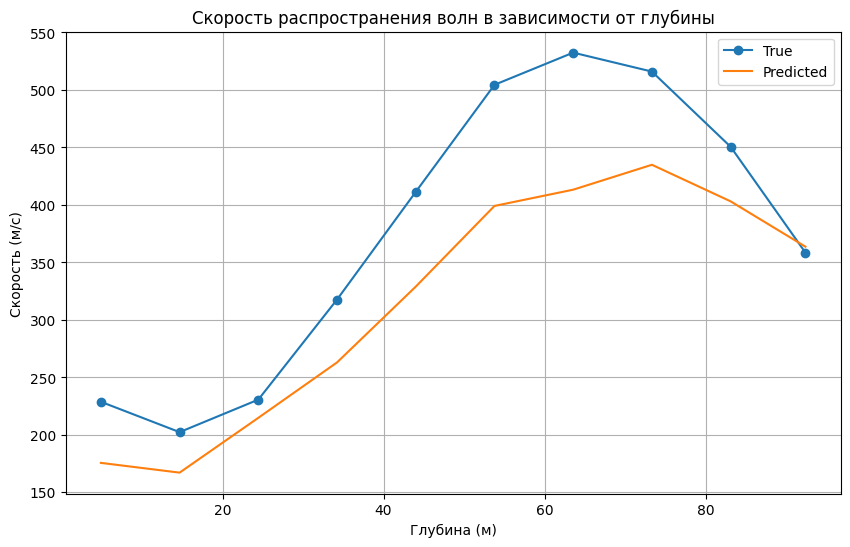

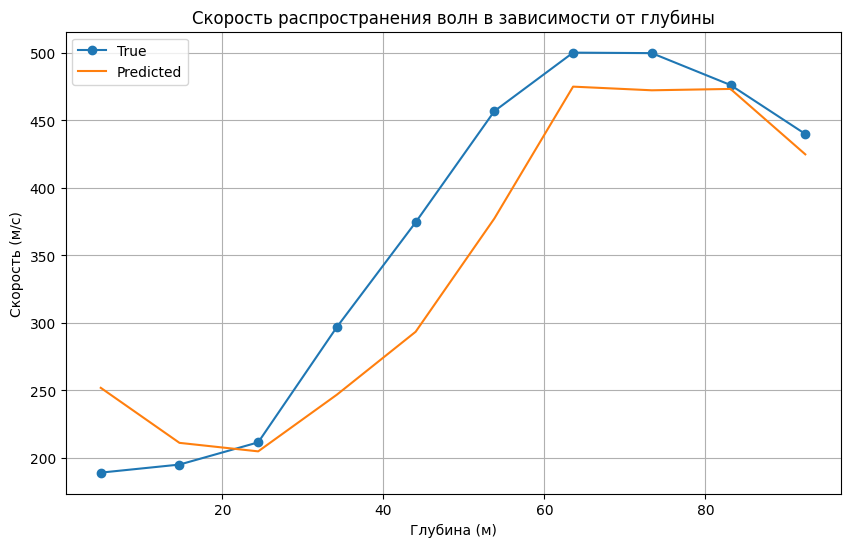

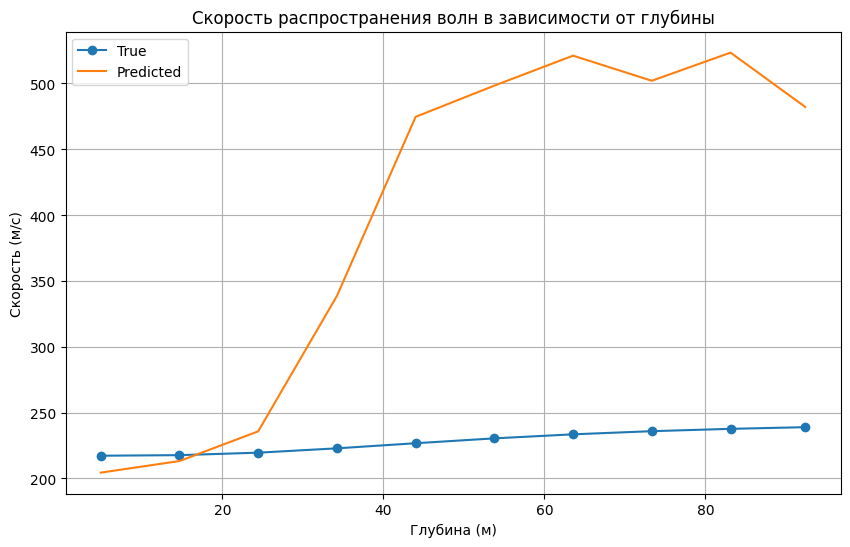

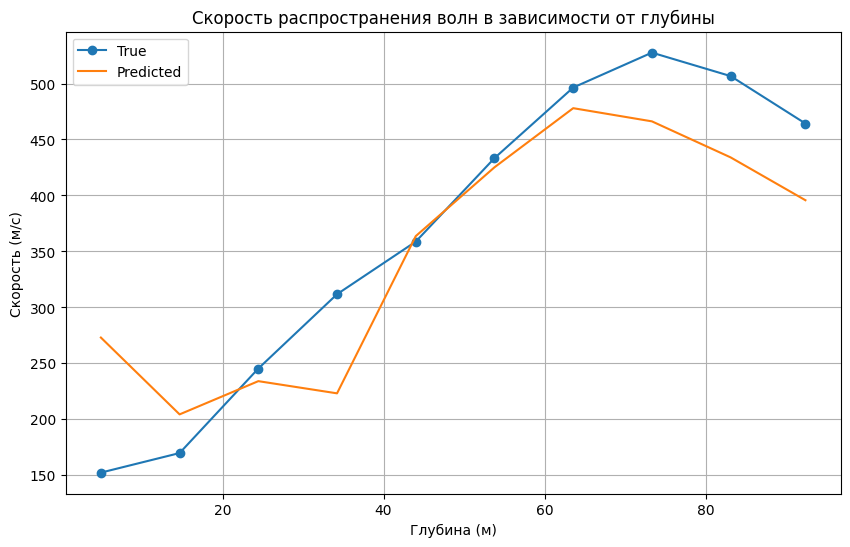

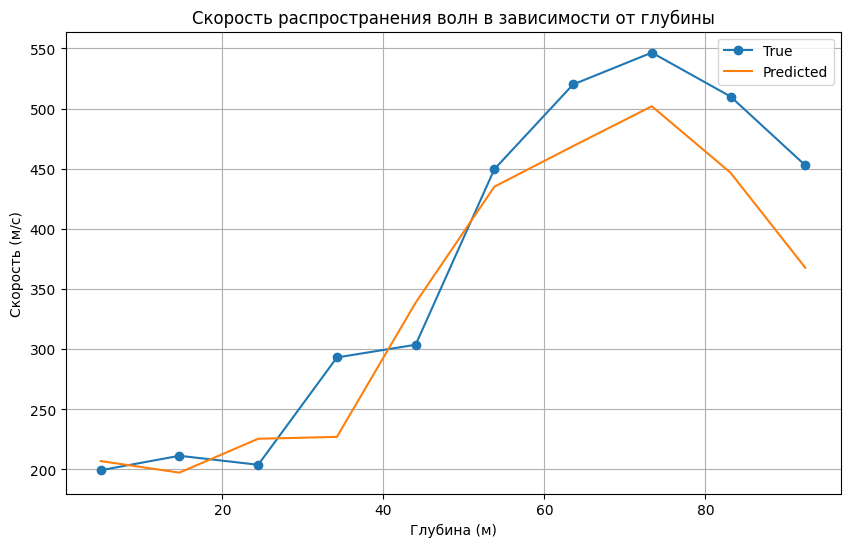

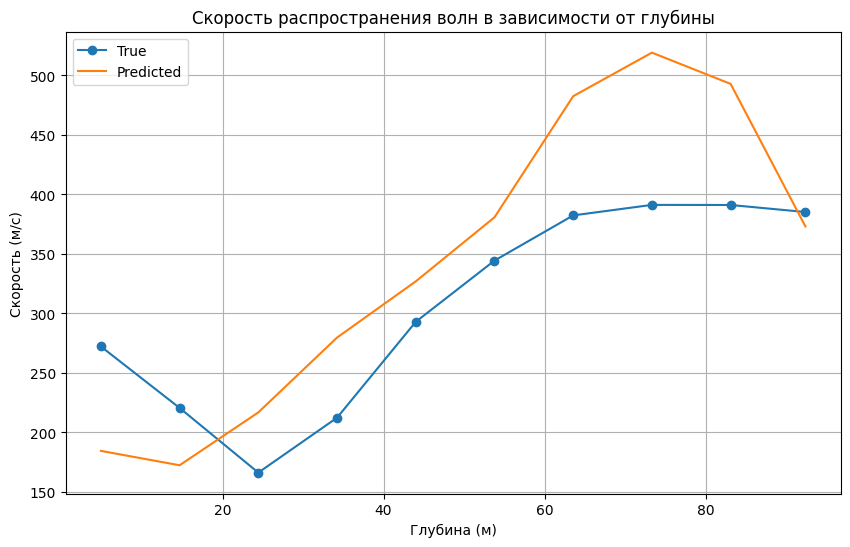

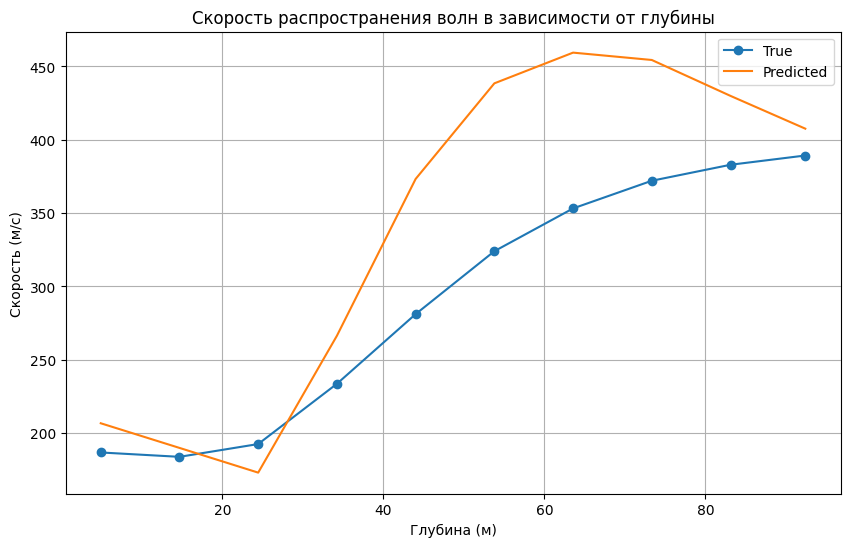

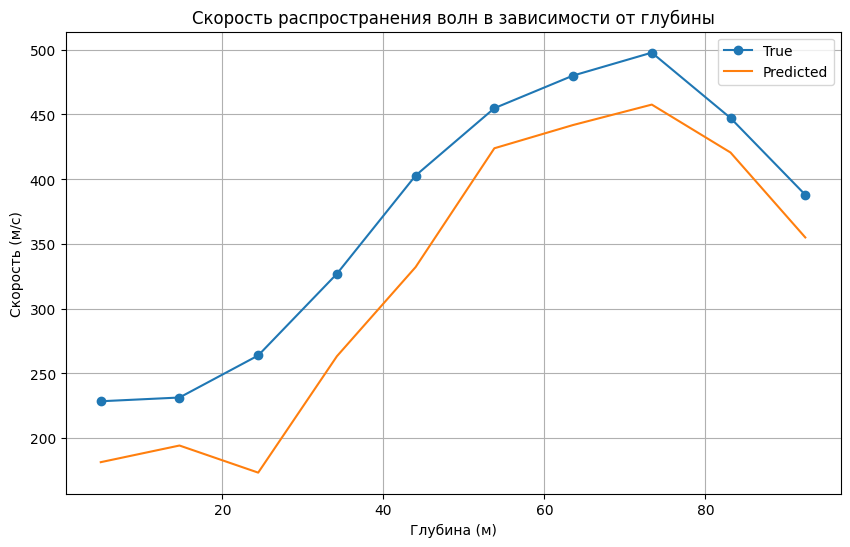

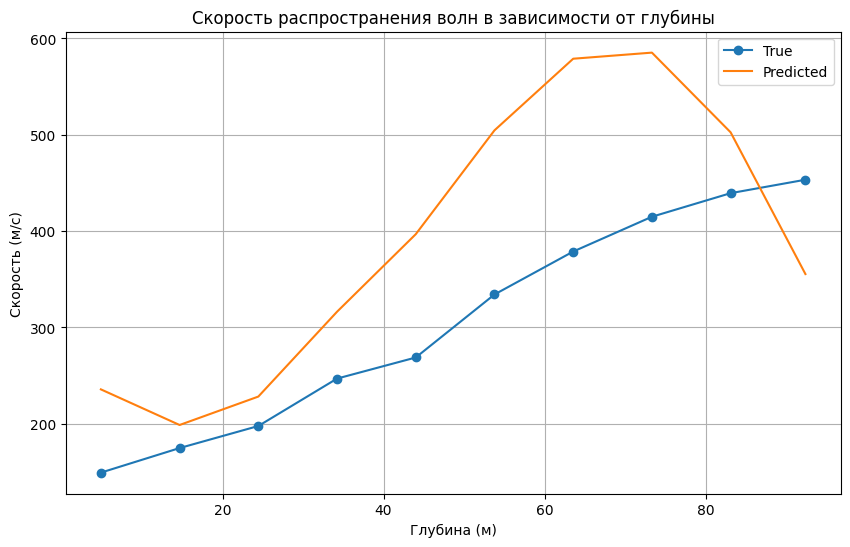

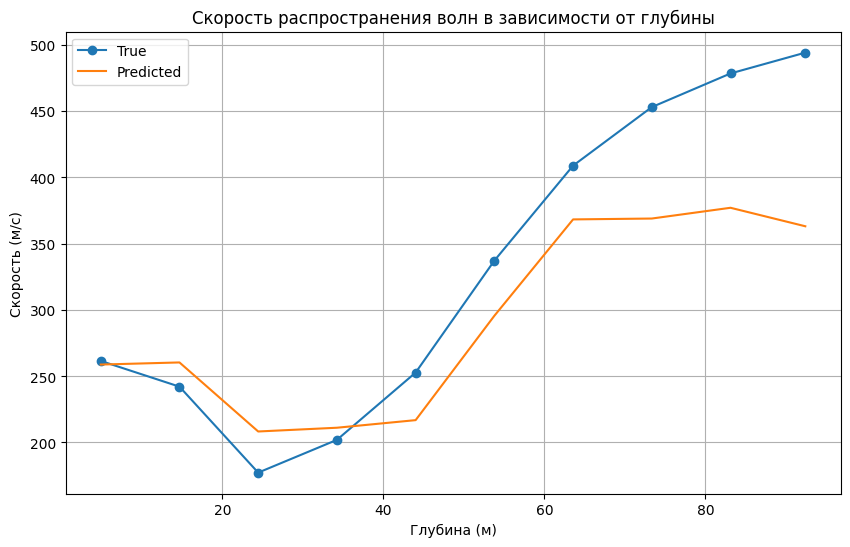

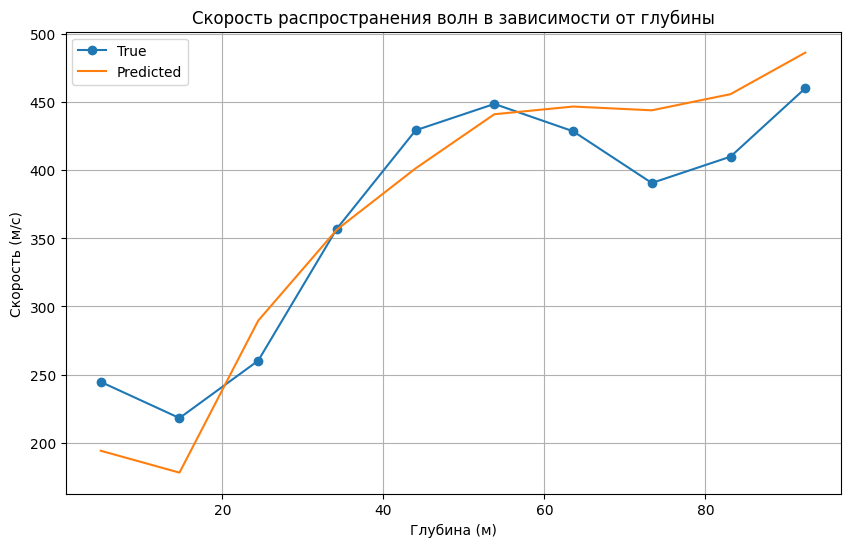

In [26]:
for i in range(15):
    a = model(torch.tensor(X_test[i].reshape(1,1,33,438)).to(device)).cpu().detach().numpy()
    plt.figure(figsize=(10, 6))
    plt.plot([4.889, 14.667, 24.444, 34.222, 44, 53.778, 63.556, 73.333, 83.111, 92.4], y_val[i], marker='o', label='True')
    plt.plot([4.889, 14.667, 24.444, 34.222, 44, 53.778, 63.556, 73.333, 83.111, 92.4], a.flatten(), label='Predicted')
    plt.xlabel('Глубина (м)')
    plt.ylabel('Скорость (м/с)')
    plt.title('Скорость распространения волн в зависимости от глубины')
    plt.grid(True)
    plt.legend()
    plt.savefig(f'../reports/figures/comprasion{i}.png')
    plt.show()

In [43]:
torch.onnx.export(model, torch.tensor(X_test[i].reshape(1,1,33,438)).to(device), '../models/model.onnx')